In [1]:
import math
import random
import os
import time
import numpy as np
import pickle
import subprocess

from tqdm import tqdm
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from env import ElastisityEnv


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def optimize_model(policy_net, target_net, memory, optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

def select_action(state, policy_net, env):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.25
EPS_DECAY = 2000
TAU = 0.005
LR = 1e-4

LOAD_WEIGHTS = False
SAVE_WEIGHTS = False

# shared reward
alpha = 0.7
beta = 0.3

n_agents = 3
envs = [ElastisityEnv(i) for i in range(1, n_agents + 1)]
# Get number of actions from gym action space
n_actions = envs[0].action_space.n
# Get the number of state observations
state = envs[0].reset()
n_observations = len(state) * len(state[0])
print(f"Number of observations: {n_observations} and number of actions: {n_actions}")

agents = [DQN(n_observations, n_actions).to(device) for _ in range(n_agents)]
if LOAD_WEIGHTS:
    for i, agent in enumerate(agents):
        agent.load_state_dict(torch.load(f'models/mdqn/model_weights_agent_{i}.pth'))
    print(f"Loaded weights for agents")

target_nets = [DQN(n_observations, n_actions).to(device) for _ in range(n_agents)]
memories = [ReplayMemory(1000) for _ in range(n_agents)]
optimizers = [optim.AdamW(agent.parameters(), lr=LR, amsgrad=True) for agent in agents]

for target_net, agent in zip(target_nets, agents):
    target_net.load_state_dict(agent.state_dict())

steps_done = 0
ep_summed_rewards = []
ep_latencies = []


Observable pods/nodes:
e6-orancloud:193.2.205.13, ca: 10.1.28.195, pods: []
raspberrypi1:193.2.205.192, ca: 10.1.245.1, pods: [('localization-api1', 'localization-api', '10.1.245.8'), ('localization-api3', 'localization-api', '10.1.245.9')]
raspberrypi2:193.2.205.183, ca: 10.1.225.1, pods: [('localization-api2', 'localization-api', '10.1.225.10')]

Observable pods/nodes:
e6-orancloud:193.2.205.13, ca: 10.1.28.195, pods: []
raspberrypi1:193.2.205.192, ca: 10.1.245.1, pods: [('localization-api1', 'localization-api', '10.1.245.8'), ('localization-api3', 'localization-api', '10.1.245.9')]
raspberrypi2:193.2.205.183, ca: 10.1.225.1, pods: [('localization-api2', 'localization-api', '10.1.225.10')]

Observable pods/nodes:
e6-orancloud:193.2.205.13, ca: 10.1.28.195, pods: []
raspberrypi1:193.2.205.192, ca: 10.1.245.1, pods: [('localization-api1', 'localization-api', '10.1.245.8'), ('localization-api3', 'localization-api', '10.1.245.9')]
raspberrypi2:193.2.205.183, ca: 10.1.225.1, pods: [('loca

In [2]:
def select_action(state, policy_net, env):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if steps_done % 100 == 0:
        print(f"eps_threshold: {eps_threshold} at step {steps_done}")
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
ep_latencies = []


In [3]:
# in case of resetting
# envs = [ElastisityEnv(i) for i in range(1, n_agents + 1)]

In [4]:
agent_ep_summed_rewards = [[] for _ in range(n_agents)]

In [5]:
# load the cluster
spam_process = subprocess.Popen(['python', 'spam_cluster.py', '--users', '400'])

num_episodes = 3

for i_episode in tqdm(range(num_episodes)):
    # save weights every 5 episodes
    if i_episode % 5 == 0:
        for i, agent in enumerate(agents):
            torch.save(agent.state_dict(), f'models/mdqn/model_weights_agent_{i}.pth')
            print(f"Checkpoint: Saved weights for agent {i}")

    states = [env.reset() for env in envs]
    states = [torch.tensor(np.array(state).flatten(), dtype=torch.float32, device=device).unsqueeze(0) for state in states]

    step_rewards = 0
    step_latencies = []
    agents_step_reward = [[] for _ in range(n_agents)]
    for t in count():
        # time.sleep(1)

        actions = [select_action(state, agent, env) for state, agent, env in zip(states, agents, envs)]

        next_states, rewards, dones = [], [], []
        for i, action in enumerate(actions):
            # reward for efficiency
            observation, reward, done, _ = envs[i].step(action.item())
            next_states.append(np.array(observation).flatten())
            rewards.append(reward)
            dones.append(done)
            if done:
                next_states[i] = None

        # latencies = [env.calculate_latency() for env in envs]
        # latenices_for_agent.append(latencies[0])
        # print(latencies)
        # shared_rewards = [alpha * reward + beta * (1 - np.mean(latencies) * 10) for reward in rewards]
        
        # calculate mean/geomean latency for the system, it doesnt matter which agent we use
        latency = envs[0].calculate_latency(30)
        step_latencies.append(envs[0].calculate_latency(1)) # without geo. mean
        shared_rewards = [alpha * reward + beta * (1 - latency * 100) for reward in rewards]

        if t % 25 == 0:
            print(f"SharedR A*r+B*L: {shared_rewards}, reward_part: {rewards}, latency_part: {latency}. Step: {t}")

        [agents_step_reward[i].append(shared_rewards[i]) for i in range(n_agents)]

        # each agent has its own latency, so it isnt a shared reward
        # shared_rewards = [alpha * reward + beta * (1 - latency * 10) for reward, latency in zip(rewards, latencies)]

        # print(f"Rewards: {shared_rewards}, step: {t}")
        step_rewards += np.mean(shared_rewards)

        next_states = [torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0) if observation is not None else None for observation in next_states]
        rewards = [torch.tensor([reward], device=device) for reward in shared_rewards]

        for i in range(n_agents):
            memories[i].push(states[i], actions[i], next_states[i], rewards[i])

        states = next_states
        for i in range(n_agents):
            optimize_model(agents[i], target_nets[i], memories[i], optimizers[i])
        
        for agent, target_net in zip(agents, target_nets):
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = agent.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

        if any(dones):
            break
    
    ep_latencies.append(np.mean(step_latencies))
    ep_summed_rewards.append(step_rewards)
    
    [agent_ep_summed_rewards[i].append(np.sum(reward)) for i, reward in enumerate(agents_step_reward)]
    print(f"Episode {i_episode} reward: {step_rewards} mean latency: {np.mean(step_latencies)}")

spam_process.terminate()
print(f'Complete with {np.mean(ep_summed_rewards)} rewards')

if SAVE_WEIGHTS:
    for i, agent in enumerate(agents):
        torch.save(agent.state_dict(), f'models/mdqn/model_weights_agent_{i}.pth')

  0%|          | 0/3 [00:00<?, ?it/s]

Checkpoint: Saved weights for agent 0
Checkpoint: Saved weights for agent 1
Checkpoint: Saved weights for agent 2
eps_threshold: 0.9 at step 0
Pod localization-api3 patched successfully to 450m request and 450m limit
SharedR A*r+B*L: [-1.3537327126861571, -1.349986312686157, -1.355521212686157], reward_part: [-1.990918, -1.985566, -1.993473], latency_part: 0.008669670422871907. Step: 0
Pod localization-api1 patched successfully to 450m request and 450m limit
Pod localization-api2 patched successfully to 550m request and 550m limit
Pod localization-api3 patched successfully to 397m request and 397m limit
Error making prediction: {"detail":"Error making prediction"}
Pod localization-api1 patched successfully to 497m request and 497m limit
Pod localization-api2 patched successfully to 602m request and 602m limit
Error making prediction: {"detail":"Error making prediction"}
Pod localization-api1 patched successfully to 550m request and 550m limit
Pod localization-api2 patched successfully 

 33%|███▎      | 1/3 [00:53<01:46, 53.39s/it]

Episode 0 reward: -62.90444998800188 mean latency: 0.018814001083374023
Error making prediction: {"detail":"Error making prediction"}
SharedR A*r+B*L: [-1.5503793710001097, -1.5916255139802324, -1.552755179885864], reward_part: [-1.757700987306065, -1.8166240487062404, -1.761095], latency_part: 0.020666289329528808. Step: 0
Pod localization-api1 patched successfully to 659m request and 659m limit
Pod localization-api2 patched successfully to 607m request and 607m limit
Pod localization-api3 patched successfully to 450m request and 450m limit
Pod localization-api1 patched successfully to 707m request and 707m limit
Pod localization-api2 patched successfully to 554m request and 554m limit
Error making prediction: {"detail":"Error making prediction"}
Error making prediction: {"detail":"Error making prediction"}
Pod localization-api1 patched successfully to 659m request and 659m limit
Pod localization-api2 patched successfully to 502m request and 502m limit
Pod localization-api1 patched su

 67%|██████▋   | 2/3 [01:42<00:50, 50.74s/it]

Episode 1 reward: -59.14143745447095 mean latency: 0.017369041442871092
eps_threshold: 0.8094601846762876 at step 300
Error making prediction: {"detail":"Error making prediction"}
Pod localization-api1 patched successfully to 869m request and 869m limit
Pod localization-api3 patched successfully to 817m request and 817m limit
SharedR A*r+B*L: [-1.5997589721530254, -1.6387218593206931, -1.5811367940671714], reward_part: [-1.7995788900979326, -1.855240157480315, -1.7729757785467128], latency_part: 0.021335124969482422. Step: 0
Pod localization-api2 patched successfully to 812m request and 812m limit
Pod localization-api2 patched successfully to 864m request and 864m limit
Pod localization-api3 patched successfully to 864m request and 864m limit
Error making prediction: {"detail":"Error making prediction"}
Pod localization-api3 patched successfully to 817m request and 817m limit
Error making prediction: {"detail":"Error making prediction"}
Pod localization-api1 patched successfully to 817

100%|██████████| 3/3 [02:34<00:00, 51.66s/it]

Episode 2 reward: -73.58676271529264 mean latency: 0.01690262317657471
Complete with -65.21088338592182 rewards


In [52]:
spam_process.terminate()

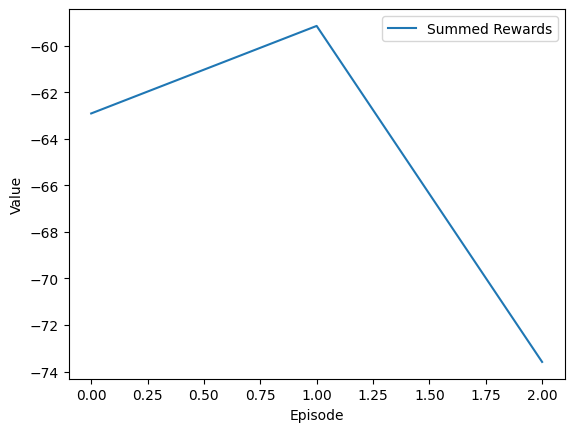

<module 'matplotlib.pyplot' from '/home/jprodanov/resource-elastisity-nancy/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [6]:
import matplotlib.pyplot as plt

plt.plot(ep_summed_rewards, label='Summed Rewards')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.show()
plt

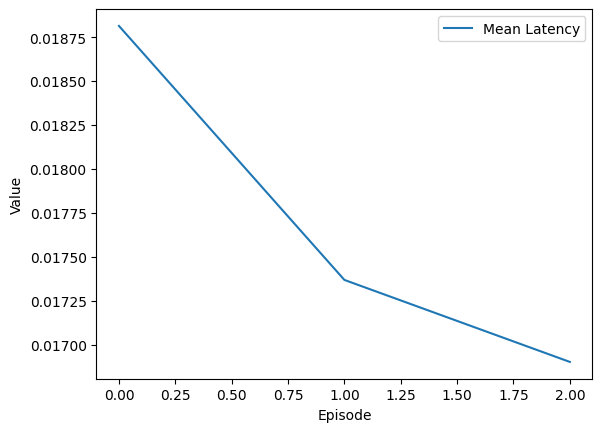

<module 'matplotlib.pyplot' from '/home/jprodanov/resource-elastisity-nancy/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [7]:
plt.plot(ep_latencies, label='Mean Latency')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.show()
plt

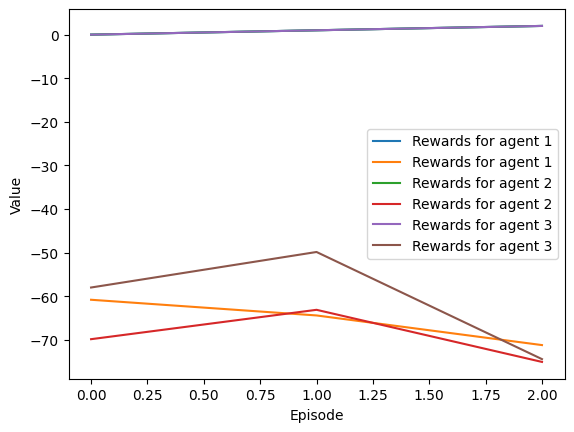

In [20]:
for i, rewards in enumerate(agent_ep_summed_rewards):
    plt.plot(rewards, label=f'Rewards for agent {i + 1}')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.show()

read back saved data

In [36]:
import pandas as pd

ep_summed_rewards_df = pd.read_csv('model_metric_data/ep_summed_rewards.csv')

ep_latencies_df = pd.read_csv('model_metric_data/ep_latencies.csv')

num_agents = 3
agent_ep_summed_rewards = []
for agent_idx in range(num_agents):
    filename = f'model_metric_data/agent_{agent_idx}_ep_summed_rewards.csv'
    agent_rewards_df = pd.read_csv(filename)
    agent_ep_summed_rewards.append(agent_rewards_df)

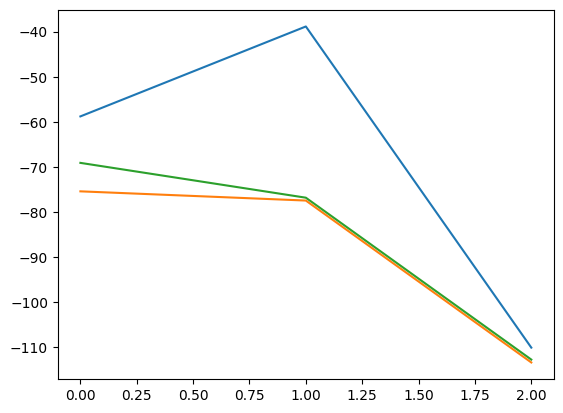

In [37]:
for i in range(len(agent_ep_summed_rewards)):
    plt.plot(agent_ep_summed_rewards[i]['Episode'], agent_ep_summed_rewards[i]['Reward'], label=f'Agent {i}')

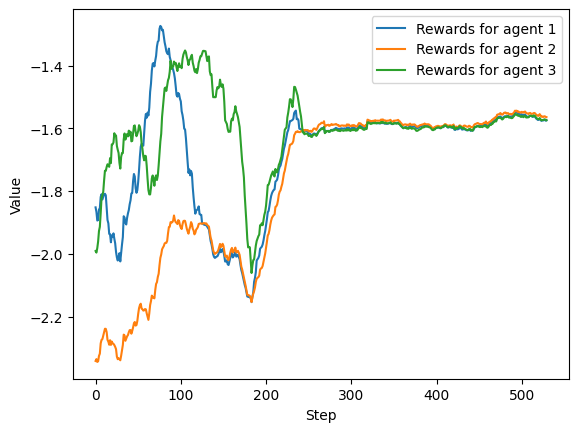

In [55]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

window_size = 50
for i, rewards in enumerate(agents_step_reward):
    rewards_smooth = moving_average(rewards, window_size)
    # rewards_smooth = rewards
    plt.plot(rewards_smooth, label=f'Rewards for agent {i + 1}')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In case of chaning the env

In [8]:
import random
import time
import numpy as np
from gymnasium import Env
from gymnasium import spaces

from utils import make_request, init_nodes
from pod_controller import get_loadbalancer_external_port, patch_pod

class ElastisityEnv(Env):
    def __init__(self, id):
        super().__init__()
        self.MAX_CPU_LIMIT = 1000
        self.MIN_CPU_LIMIT = 50
        self.INCREMENT = 50
        # self.START_CPU = 100

        self.action_space = spaces.Discrete(3)
        nodes = init_nodes(debug=True, custom_label='app=localization-api')

        self.id = id
        for node in nodes:
            for container_id, (pod_name, container_name, pod_ip) in list(node.get_containers().items()):
                if pod_name == f'localization-api{self.id}':
                    # select node and container_id for agent
                    self.container_id = container_id
                    self.node = node
                    break

        # self.which_node = 1
        # self.node = next((node for node in nodes if node.name == 'raspberrypi' + str(self.which_node)), None
        self.STATE_LENTGH = 8
        # init state with random values
        self.states_fifo = [[random.random(), random.random(), random.random()] for _ in range(self.STATE_LENTGH)]
        self.state = self.get_current_usage()

        self.steps = 0
        self.MAX_STEPS = 50

        # 30% - 60%
        self.UPPER_CPU = 60
        self.LOWER_CPU = 30

        self.loadbalancer_port = get_loadbalancer_external_port(service_name='ingress-nginx-controller')

    def step(self, action):
        if action == 0:
            self.decrease_resources()
        elif action == 2:
            self.increase_resources()

        self.state = self.get_current_usage()

        # latency = self.calculate_latency(1)
        # reward = 1 - latency
        # reward = 1 - latency * 10

        if self.last_cpu_percentage < self.LOWER_CPU:
            usage_penalty = 2 - self.state[-1][2]
        elif self.last_cpu_percentage > self.UPPER_CPU:
            usage_penalty = self.state[-1][2]
        else:
            usage_penalty = 0

        reward = - usage_penalty

        # print(f"Steps {self.steps} Reward: {reward}, State {self.state}")

        self.steps += 1
        if self.steps >= self.MAX_STEPS:
            print(f"Max steps reached")
            done = True
        else:
            done = False

        return self.state, reward, done, 0
    
    def reset(self):
        self.state = self.get_current_usage()
        self.steps = 0
        # patch_pod('localization-api1', cpu_request=f"{self.START_CPU}m", cpu_limit=f"{self.START_CPU}m", container_name='localization-api', debug=True)
        return self.state

    def normalize_cpu_usage(self, cpu_usage):
        # normalized_cpu_usage = (cpu_usage - 0) / (self.MAX_CPU_LIMIT - 0)
        normalized_cpu_usage = (cpu_usage - self.MIN_CPU_LIMIT) / (self.MAX_CPU_LIMIT - self.MIN_CPU_LIMIT)
        return normalized_cpu_usage

    def get_current_usage(self):
        # for node in self.nodes:
        # for container_id, (pod_name, container_name, pod_ip) in list(self.node.get_containers().items()):
        (cpu_limit, cpu, cpu_percentage), (memory_limit, memory, memory_percentage), (rx, tx) = self.node.get_container_usage(self.container_id)
        self.last_cpu_percentage = cpu_percentage
            # states = ([cpu_limit, cpu, memory_limit, memory, rx, tx])
        n_cpu_limit, n_cpu = self.normalize_cpu_usage(cpu_limit), self.normalize_cpu_usage(cpu)
            
        state = [n_cpu_limit, n_cpu, (cpu_percentage / 100)]
        
        self.states_fifo.append(state)
        self.states_fifo.pop(0)

        return self.states_fifo

    def increase_resources(self):
        # for node in self.nodes:
        # for container_id, (pod_name, container_name, pod_ip) in list(self.node.get_containers().items()):
        cpu_limit, memory_limit = self.node.get_container_limits(self.container_id)
        cpu_limit = min(cpu_limit + self.INCREMENT, self.MAX_CPU_LIMIT)  
        
        patch_pod(f'localization-api{self.id}', cpu_request=f"{cpu_limit}m", cpu_limit=f"{cpu_limit}m", container_name='localization-api', debug=True)

    def decrease_resources(self):
        # for node in self.nodes:
        # for container_id, (pod_name, container_name, pod_ip) in list(self.node.get_containers().items()):
        cpu_limit, memory_limit = self.node.get_container_limits(self.container_id)
        cpu_limit = max(cpu_limit - self.INCREMENT, self.MIN_CPU_LIMIT)

        patch_pod(f'localization-api{self.id}', cpu_request=f"{cpu_limit}m", cpu_limit=f"{cpu_limit}m", container_name='localization-api', debug=True)

    def calculate_latency(self, num_requests):
        url = f"http://localhost:{self.loadbalancer_port}/predict"
        latencies = []
        for _ in range(num_requests):
            data = {
                "feature": random.randint(0, 130)
            }
            latency = make_request(url, data)
            if latency:
                latencies.append(latency)
        a = np.array(latencies)
        # return a.prod()**(1.0/len(a))
        return a.mean() if len(a) > 0 else 0
